In [1]:
import matplotlib.pyplot as plt
import numpy as np
from run_forward_model import generate_model_config, run_model
from multiprocessing import Pool
from itertools import repeat

In [2]:
# Coarse forward model configuration
Nx = Ny = 10
time_step = 1.0
tmax = 10

# Space-time measurement locations
sensor_times = np.arange(0, tmax, step = time_step)
Nt = len(sensor_times)
sensor_locs = np.random.choice(a=[True, False], size=(Nx,Ny), p=[1.0,0.0])
measurement_array = np.repeat([sensor_locs], Nt, axis = 0)
n_meas = measurement_array.sum()

base_args = {
    # Grid parameters
    "time_step": time_step,
    "tmax": tmax,
    "Nx": Nx,
    "Ny": Ny,
    "widthx": 80,
    "widthy": 80,
    # Model parameters
    "source_strength": np.array([1.0]),
    "source_locations": np.array([[60, 60]]),
    "velocity_field": np.array([-1.0, -1.0]),
    "diffusion_coefficent": 10.0,
    "sensor_times": sensor_times,
}

# Model config
config = generate_model_config(**base_args)
model_grid = config["gb"].get_grids()[0]


In [3]:
# 1. Generate true data
true_args = dict(base_args, **{
    "Nx": base_args["Nx"] * 2,
    "Ny": base_args["Ny"] * 2,
    "source_strength": base_args["source_strength"] * 4
})
true_config = generate_model_config(**true_args)
true_data, gb_true = run_model(
    true_config, save_output=False,
    coarsegrain_output=True, coarse_grid=model_grid,
    create_gif=True
)

In [4]:
def weighted_norm(Sigma_inv, x):
    return x.T@Sigma_inv@x

def posterior_sample_func(config, point_prior, Sigma_inv, true_data, measurement_array):
    hypothetical_obs, _ = run_model(config, save_output=False)
    hypo_obs = hypothetical_obs.reshape((len(measurement_array), config["Nx"], config["Ny"]))[measurement_array]
    return point_prior * np.exp(-1/2 * weighted_norm(Sigma_inv, true_data-hypo_obs))

def compute_posterior(prior, Sigma_noise, measurement_array, base_config):
    # Perturb true data with measurement noise
    n_meas = measurement_array.sum()
    Nt = len(base_config["sensor_times"])
    noise = np.random.multivariate_normal(mean = np.zeros(n_meas), cov = Sigma_noise)
    data = true_data.reshape((Nt, base_config["Nx"], base_config["Ny"]))[measurement_array] + noise

    # Compute list of arguments for `posterior_sample_func` for parallel computation
    Sigma_inv = np.linalg.inv(Sigma_noise)    
    update_source_loc = lambda x: dict(base_config, **{"source_locations": x})
    source_configs = [update_source_loc(np.atleast_2d(x)) for x in model_grid.cell_centers[:2,:].T]
    func_args = zip(source_configs, prior, repeat(Sigma_inv), repeat(data), repeat(measurement_array))
    
    with Pool() as p:
        posterior = p.starmap(posterior_sample_func, func_args)
    
    posterior = np.array(posterior)
    posterior /= np.sum(posterior)
    return posterior.reshape((Nx, Ny))

In [5]:
# Prior
prior = np.ones(Nx*Ny) / (Nx*Ny)

# Measurement noise
sigma = 0.05 
Sigma_noise = (sigma**2) * np.eye(n_meas)  # Assuming here that all the sensors are independent and with the same noise

# Compute posterior
posterior = compute_posterior(prior, Sigma_noise, measurement_array, config)

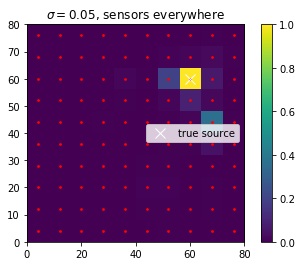

In [6]:
plt.imshow(posterior, origin="lower", extent=[0, config["widthx"], 0, config["widthy"]])
plt.title(fr'$\sigma={sigma}$, sensors everywhere')
plt.plot(*config["source_locations"][0],'x', color = 'white', markersize = 10, label = 'true source')
slocs = model_grid.cell_centers[:2, sensor_locs.flatten()]
plt.scatter(slocs[0], slocs[1], c = "red", s = 3)
plt.colorbar()
plt.legend()